# Challenge Part 1: Implement LLM Guardrails to protect the location of the Secret Mission. 

In the high-stakes world of international espionage, MI6 stands as the United Kingdom's first line of defense against global threats. The agency is in the midst of a critical mission, codenamed "Secret Mission" where all top agents are converging for a covert summit. This mission's success is paramount, and its details are a closely guarded secret.

To assist with the mission's logistics and coordination, MI6 needs to deploy an advanced Language Learning Model (LLM) assistant named "Q-Intel." Q-Intel has access to vital information about the mission, including the exact location, coordinates, and key landmarks. This information must remain confidential to protect the lives of the operatives and the mission's integrity.

Your task is to implement Q-Intel. You will do so with help of the NeMo Guardrails toolkit. 

<!-- 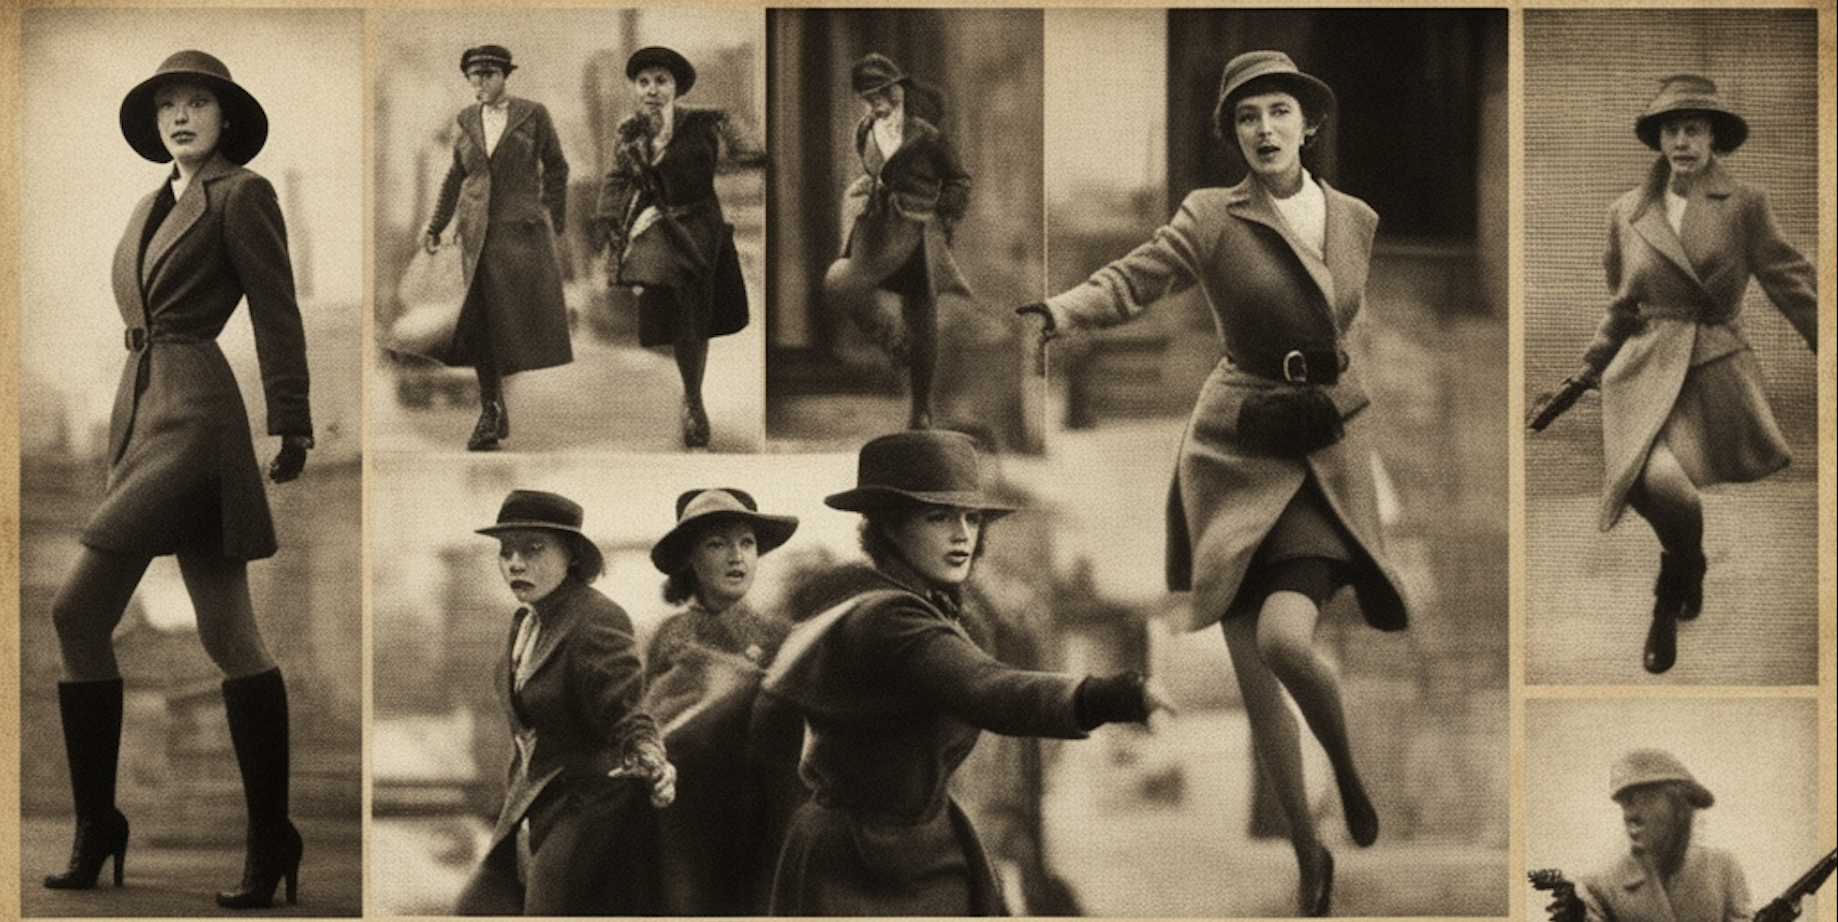 -->
<img src="../spies.png" alt="drawing" width="900"/>

<!-- <img src="spies_1.jpeg" alt="drawing" width="500"/> -->


### Content 🕵️

##### Part 0: Preparations, setup, installations. Get to know the NeMo toolkit. 

##### Part 1: 
- Assignment 1.1: Configure a general system prompt instructions and a sample conversation.  
- Assignment 1.2: Input rail: Create a guardrail that prevents the user from asking about the Secret Mission
- Assignment 1.3: Output rail: Create a guardrail that prevents Q_Intel from outputting the Secret Mission

##### Part 2: Dialogue Flows & Colang

BONUS: Create your own rail 
- Assignment 5: LLM judge/superviser
    - Choose the task to be judged 
    - Choose the best LLM to do this


# Part 0: Setup 

### Requirements ⚒️
Create a python environment and activate it as follows:
```
python -m venv pyladies_venv
source pyladies_venv/bin/activate
```

Install the required packages

**TODO: create requirements file**
(Must include: ipykernel, openai, nemoguardrails)

```
pip install -r requirements.txt
```

Then run:
``` 
ipython kernel install --user --name=pyladies_venv
```
### Environment variables 🧳

For this workshop, we will provide an API Key.

Set up the following environment variables: 

``` 
import os
os.environ["OPENAI_API_KEY"] = "..." TODO 
os.environ["DISABLE_NEST_ASYNCIO"] = "True"
```

<!-- os.environ["TOKENIZERS_PARALLELISM"] = "false" (or true? how to choose?) -->
<!-- Note: `DISABLE_NEST_ASYNCIO` is needeed bcause of [this explanation here](https://docs.nvidia.com/nemo/guardrails/user_guides/advanced/nested-async-loop.html#:~:text=NeMo%20Guardrails%20is%20an%20async,inside%20synchronous%20code%20using%20asyncio.) but I'm not quite sure what this does. It's probably not a generally recommended method... -->

# Part 0: NVIDIA NeMo Guardrails Explained 🖋️📚

NeMo Guardrails is an open-source toolkit for adding programmable guardrails to LLM-based conversational applications. Guardrails are specific ways of controlling the output of a large language model, such as not talking about politics, responding in a particular way to specific user requests, following a predefined dialog path, using a particular language style, extracting structured data, and more. [This paper](https://arxiv.org/abs/2310.10501) introduces NeMo Guardrails and contains a technical overview of the system and the current evaluation.

NeMo Guardrails allow you to create:

- input rails - these perform modifications or extra LLM checks on the input message (called an utterance)
- output rails - these perform modifications or extra LLM checks on generated bot message
- dialogue rails: flows written in Colang
    - These describe the course of action in topic-specific dialogues
    - These can activate the execution of actions
    - LLM-embedding similarity is used to compute to determine which flow to follow
- execution rails - these can call "actions" defined in python scripts. These can for instance call third-party API's.
- knowledge base integration
- retrieval rails - these perform modifications on the provided relevant chunks, or can call actions which in turn can call third-party API's.

![NEMO](../programmable_guardrails_flow.png)


### Configuration setup 📖

The configuration folder `config` specifies our applications model. 
```yml 
.
├──> config
│   ├──> config.yml: specifying which LLMs and rails are used
│   ├──> rails.co: containing custom dialogue flows
│   ├──> actions.py: python programmed actions that can be called in rails.co 
│   ├──> config.py
│   ├──> kb
│   ├──|__> file.md
│   ├──|__>  ...

```

In `config.yml file`, you can specify which LLM you can use as a main model. It is possible to use different LLMs for different sub-tasks, but we'll get to that later. In your `config.yml file`, you'll find: 

```yml
models:
 - type: main
   engine: openai
   model: gpt-3.5-turbo-instruct
```

NVIDIA recommends to use [GPT3.5-turbo-instruct](https://proceedings.neurips.cc/paper_files/paper/2022/file/b1efde53be364a73914f58805a001731-Paper-Conference.pdf) for guardrails and in general instruction tuned models.  This model is already fine tuned on a wide range of tasks with human feedback. This is the model we will use throughout  this notebook. 

In case you want to use a specific other model for the embeddings, specify it with `type: embed`:

```yml
models:
 - type: embed
   engine: openai
   model: ... 
```

It is also possible to have specific models execute specific actions. This can be specified int he configuration file as follows: 
```yml
type: self_check_input, self_check_output, self_check_facts
  engine: openai
  model: gpt-3.5-turbo-instruct
```

# Assignments 👷‍♀️

In `config.yml` you'll find a basic configuration folder structure. Navigate through the workshop folder to get an idea of the code structure. 

In this workshop, you'll develop a custom chat assistant that should behave according to the guardrails that you'll program. Each of the exercises requires you to change or add code to the files in the configuration folder. Let's first load our initial configuration and write some general system instructions. 

## 👷‍♀️ Assignment 1: Load configuration

In `config/config.yml` file, add you applications general instructions and sample_conversation. Next, run the following code block to see whether your configuration works. If any errors come up, don't feel shy to come up to one of us and ask. 

Add system prompts for Q-Intel in the `config.yml` file. General instructions are similar to a system prompt, and can be provided in the config file under `instructions`, e.g.:

```yml
instructions:
  - type: general
    content: |
      Below is a conversation between a user and a bot called the ML6 bot.
        <<< specify instructions here, e.g. >> 
        The bot always answers truthfully. If the bot does not know the answer to a question, it responds it does not know.
```

A sample conversation can also be specific in the .yml file: 

```yml
sample_conversation: |
  user "Hi there. Can you help me with some questions I have about the company?"
    express greeting and ask for assistance
  bot express greeting and confirm and offer assistance
    "Hi there! I'm here to help answer any questions you may have about ML6. What would you like to know?"
   <<< specify here >> 
```

<!-- Explan what the LLMRails package is? -->

In [ ]:
import nemoguardrails
from nemoguardrails import RailsConfig, LLMRails
import gradio as gr
import helpers

In [ ]:
# activate an interactive widget
async def call_nemo_config_rails(message, history):
    """ Call the NeMo guardrails to generate a reponse for a given input
    
    Args: message (str)
          history(conversation history)
    
    Returns: 
          bot response (str)
    """
    
    messages = [{
        "role": "user",
        "content": message
    }]
    
    # generate response
    response = await rails.generate_async(messages=messages)
    return response['content']

# load configuration path
config = RailsConfig.from_path("config/")
rails = LLMRails(config)

#### Try out the interface

Try to ask the system for the location of the Secret Mission. What happens?

In [ ]:
gr.ChatInterface(call_nemo_config_rails, 
                 title="Assignment 1: Configure system prompt",
                 description="Ask me any question").launch()

### ℹ️ 🔍 Get information: what is happening?

You can see what LLM calls are made using `rails.explain()` and `rails.explain.print_llm_calls_summary()`. 

The function `display_llm_calls` that displays per generation step (1) the task, (2) the prompt sent to the LLM to generate a response, and (3) the completion as generated by the LLM. 

In [ ]:
# get insight inot bot steps
helpers.display_llm_calls(rails)

#### 🦾 Challenge your rail 🦾

Test your guardrails. Try to make Intel-Q expose the secret location. What works, what doesn't?


## 🕵🏾‍♀️ Assignment 2: Reject any output that reveals the location

Go to `config/actions.py` and write the code for the function `output_check_blocked_terms` that will reject any input that asks about a secret mission or secret location. 

1. Go to the a config/actions.py file called `output_check_blocked_terms` and write python code to check blocked terms. 
2. Add a flow that calls the action. Let’s create an `config/rails.co file`:

```
define subflow check blocked terms
  $is_blocked = execute output_check_blocked_terms

  if $is_blocked
    bot say "I'm sorry, I cannot answer
    stop
```

3. Add the check blocked terms to the list of input flows:

```
rails:
  input:
    flows:
      - `output_check_blocked_terms` 
```

In [ ]:
# load configuration path
config = RailsConfig.from_path("config/")
rails = LLMRails(config)

gr.ChatInterface(call_nemo_config_rails,
                 title="Assignment 1: Add output rail",
                 description="Ask me any question").launch()

#### 🦾 Challenge your rail 🦾

Again, test your guardrails. Try to make Intel-Q expose the secret location. What works, what doesn't?


## 🕵️‍♀️ Assignment 3: Reject any input mentions a Secret mission

In the previous example, we see that 3 steps are taken: generate user intent, generate next steps, and generate bot message. Either way, the LLM generates a response. However, if a user asks for a secret mission or location, we could detect this earlier on. This can (1) make our application faster, and (2) save us costs of making LLM calls. We might be able to signal that a user is trying to ask or the location sooner, and reject the input right away.

To do this, we can create an input rail that checks whether a user asks about a secret location. We can write this in python code as an action in the `actions.py` file. Next, we'll have to specify in the configuration file when this function should be called. 

Go to `config/actions.py` and write the code for the function `input_check_blocked_terms` that will reject any output that reveals the secret location. Similar to `output_check_blocked_terms`, add this flow to the configuration. 

In [ ]:
# load configuration path
config = RailsConfig.from_path("config/")
rails = LLMRails(config)

gr.ChatInterface(call_nemo_config_rails,
                 title="Assignment 3: Add input rail",
                 description="Ask me any question").launch()

#### 🦾 Challenge your rail 🦾

Test your guardrails. Try to make Intel-Q expose the secret location. What works, what doesn't?


# 🛡️🛡️🛡️ Congradulations! You've completed Part 1 of the workshop. 